**End to End ML - Experimentation**

Importing necessary libraries

In [1]:
import os
import time

import pandas as pd
from google.cloud import aiplatform, bigquery
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

Creating a GCS bucket in the us-central1 region, to store the dataset

In [2]:
REGION = "us-central1"

PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

ARTIFACT_STORE = f"gs://{PROJECT_ID}-end-to-end-ml-experiment"

DATA_ROOT = f"{ARTIFACT_STORE}/data"
JOB_DIR_ROOT = f"{ARTIFACT_STORE}/jobs"
TRAINING_FILE_PATH = f"{DATA_ROOT}/training/dataset.csv"
VALIDATION_FILE_PATH = f"{DATA_ROOT}/validation/dataset.csv"
API_ENDPOINT = f"{REGION}-aiplatform.googleapis.com"

In [3]:
os.environ["JOB_DIR_ROOT"] = JOB_DIR_ROOT
os.environ["TRAINING_FILE_PATH"] = TRAINING_FILE_PATH
os.environ["VALIDATION_FILE_PATH"] = VALIDATION_FILE_PATH
os.environ["PROJECT_ID"] = PROJECT_ID
os.environ["REGION"] = REGION

In [ ]:
!gsutil ls | grep ^{ARTIFACT_STORE}/$ || gsutil mb -l {REGION} {ARTIFACT_STORE}

Importing the dataset into bigquery from GCS bucket

In [ ]:
%%bash

DATASET_LOCATION=US
DATASET_ID=covertype_dataset_exp
TABLE_ID=covertype_exp
DATA_SOURCE=gs://asl-public/data/covertype/dataset.csv
SCHEMA=Elevation:INTEGER,\
Aspect:INTEGER,\
Slope:INTEGER,\
Horizontal_Distance_To_Hydrology:INTEGER,\
Vertical_Distance_To_Hydrology:INTEGER,\
Horizontal_Distance_To_Roadways:INTEGER,\
Hillshade_9am:INTEGER,\
Hillshade_Noon:INTEGER,\
Hillshade_3pm:INTEGER,\
Horizontal_Distance_To_Fire_Points:INTEGER,\
Wilderness_Area:STRING,\
Soil_Type:STRING,\
Cover_Type:INTEGER

bq --location=$DATASET_LOCATION --project_id=$PROJECT_ID mk --dataset $DATASET_ID

bq --project_id=$PROJECT_ID --dataset_id=$DATASET_ID load \
--source_format=CSV \
--skip_leading_rows=1 \
--replace \
$TABLE_ID \
$DATA_SOURCE \
$SCHEMA

Fetching the dataset

In [6]:
%%bigquery
SELECT *
FROM covertype_dataset_exp.covertype_exp

Query is running:   0%|          |

Downloading:   0%|          |

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
0,2085,256,18,150,27,738,176,248,208,914,Cache,C2702,5
1,2125,256,20,30,12,871,169,248,215,300,Cache,C2702,2
2,2146,256,34,150,62,1253,122,237,239,511,Cache,C2702,2
3,2186,256,38,210,102,1294,109,232,244,552,Cache,C2702,2
4,2831,256,25,277,183,1706,153,246,225,1485,Commanche,C2705,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3136,254,12,319,60,5734,193,248,193,2467,Rawah,C7746,1
99996,3242,254,12,636,148,3551,193,248,193,2010,Commanche,C7757,0
99997,2071,255,12,234,63,342,192,247,193,247,Cache,C2706,2
99998,3248,255,12,730,113,725,192,247,193,2724,Commanche,C7756,1


Creating the training and validation splits of the dataset

**Training Split**

In [7]:
!bq query \
-n 0 \
--destination_table covertype_dataset_exp.training \
--replace \
--use_legacy_sql=false \
'SELECT *\
FROM covertype_dataset_exp.covertype_exp AS cover \
WHERE \
MOD(ABS(FARM_FINGERPRINT(TO_JSON_STRING(cover))), 10) IN (1, 2, 3, 4)'

Waiting on bqjob_r25e11f504231c19f_0000018bf207edd0_1 ... (1s) Current status: DONE   


In [8]:
!bq extract \
--destination_format CSV \
covertype_dataset_exp.training \
$TRAINING_FILE_PATH

Waiting on bqjob_r19561c50d02635a8_0000018bf20801a3_1 ... (0s) Current status: DONE   


**Validation Split**

In [9]:
!bq query \
-n 0 \
--destination_table covertype_dataset_exp.validation \
--replace \
--use_legacy_sql=false \
'SELECT *\
FROM covertype_dataset_exp.covertype_exp AS cover \
WHERE \
MOD(ABS(FARM_FINGERPRINT(TO_JSON_STRING(cover))), 10) IN (8)'

Waiting on bqjob_r3407abc47f06549b_0000018bf208203a_1 ... (1s) Current status: DONE   


In [10]:
!bq extract \
--destination_format CSV \
covertype_dataset_exp.validation \
$VALIDATION_FILE_PATH

Waiting on bqjob_r120820997640e54e_0000018bf2085a99_1 ... (0s) Current status: DONE   


Loading the training and validation data into separate variables using pandas

In [11]:
df_train = pd.read_csv(TRAINING_FILE_PATH)
df_validation = pd.read_csv(VALIDATION_FILE_PATH)

In [12]:
print(df_train.shape)
print(df_validation.shape)

(40009, 13)
(9836, 13)


**Training pipeline**

In [13]:
numeric_feature_indexes =  slice(0, 10) # ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points"]
categorical_feature_indexes =  slice(10, 12) # ["Wilderness_Area", "Soil_Type", "Cover_Type"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_feature_indexes),
        ("cat", OneHotEncoder(), categorical_feature_indexes)
    ]
)

pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", SGDClassifier(loss="log_loss", tol=1e-3))
    ]
)

Converting numeric features to float64

In [14]:
num_features_type_map = {
    feature: "float64" for feature in df_train.columns[numeric_feature_indexes]
}
print(num_features_type_map)

{'Elevation': 'float64', 'Aspect': 'float64', 'Slope': 'float64', 'Horizontal_Distance_To_Hydrology': 'float64', 'Vertical_Distance_To_Hydrology': 'float64', 'Horizontal_Distance_To_Roadways': 'float64', 'Hillshade_9am': 'float64', 'Hillshade_Noon': 'float64', 'Hillshade_3pm': 'float64', 'Horizontal_Distance_To_Fire_Points': 'float64'}


In [15]:
df_train = df_train.astype(num_features_type_map)
df_validation = df_validation.astype(num_features_type_map)

In [16]:
y_train = df_train.pop("Cover_Type")
x_train = df_train

y_validation = df_validation.pop("Cover_Type")
x_validation = df_validation

"""
x_train = df_train.drop("Cover_Type", axis=1)
y_train = df_train["Cover_Type"]
x_validation = df_validation.drop("Cover_Type", axis=1)
y_validation = df_validation["Cover_Type"]

"""

y_train.info()
y_validation.info()

<class 'pandas.core.series.Series'>
RangeIndex: 40009 entries, 0 to 40008
Series name: Cover_Type
Non-Null Count  Dtype
--------------  -----
40009 non-null  int64
dtypes: int64(1)
memory usage: 312.7 KB
<class 'pandas.core.series.Series'>
RangeIndex: 9836 entries, 0 to 9835
Series name: Cover_Type
Non-Null Count  Dtype
--------------  -----
9836 non-null   int64
dtypes: int64(1)
memory usage: 77.0 KB


In [17]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40009 entries, 0 to 40008
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Elevation                           40009 non-null  float64
 1   Aspect                              40009 non-null  float64
 2   Slope                               40009 non-null  float64
 3   Horizontal_Distance_To_Hydrology    40009 non-null  float64
 4   Vertical_Distance_To_Hydrology      40009 non-null  float64
 5   Horizontal_Distance_To_Roadways     40009 non-null  float64
 6   Hillshade_9am                       40009 non-null  float64
 7   Hillshade_Noon                      40009 non-null  float64
 8   Hillshade_3pm                       40009 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  40009 non-null  float64
 10  Wilderness_Area                     40009 non-null  object 
 11  Soil_Type                           40009

In [18]:
x_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9836 entries, 0 to 9835
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Elevation                           9836 non-null   float64
 1   Aspect                              9836 non-null   float64
 2   Slope                               9836 non-null   float64
 3   Horizontal_Distance_To_Hydrology    9836 non-null   float64
 4   Vertical_Distance_To_Hydrology      9836 non-null   float64
 5   Horizontal_Distance_To_Roadways     9836 non-null   float64
 6   Hillshade_9am                       9836 non-null   float64
 7   Hillshade_Noon                      9836 non-null   float64
 8   Hillshade_3pm                       9836 non-null   float64
 9   Horizontal_Distance_To_Fire_Points  9836 non-null   float64
 10  Wilderness_Area                     9836 non-null   object 
 11  Soil_Type                           9836 no

**Run pipeline locally**

In [19]:
pipeline.set_params(classifier__alpha=0.001, classifier__max_iter=200)
pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  slice(0, 10, None)),
                                                 ('cat', OneHotEncoder(),
                                                  slice(10, 12, None))])),
                ('classifier',
                 SGDClassifier(alpha=0.001, loss='log_loss', max_iter=200))])

Calculate trained model accuracy using validation set

In [20]:
accuracy_val = pipeline.score(x_validation, y_validation)
print(accuracy_val)

0.6929646197641317


Calculate trained model accuracy using training set

In [21]:
accuracy_train = pipeline.score(x_train, y_train)
print(accuracy_train)

0.6993926366567522


Making a directory for tuning

In [22]:
TRAINING_APP_FOLDER = "training_app"
os.makedirs(TRAINING_APP_FOLDER, exist_ok=True)

"train_evaluate" function preprocess the datasets (training and validation), fits the datasets into the model, logs model metric into hpt and saves the model in the local directory.

In [23]:
%%writefile {TRAINING_APP_FOLDER}/train.py
import os
import subprocess
import sys

import fire
import hypertune
import numpy as np
import pandas as pd
import pickle
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def train_evaluate(job_dir, training_dataset_path, validation_dataset_path, alpha, max_iter, hptune):
    
    # ----------training and preprocessing pipeline starts here
    
    df_train = pd.read_csv(training_dataset_path)
    df_validation = pd.read_csv(validation_dataset_path)
    
    if not hptune: # Concatenate the training dataset and validation dataset when not hyperparameter tuning
        df_train = pd.concat([df_train, df_validation])
    
    numeric_feature_indexes =  slice(0, 10)
    categorical_feature_indexes =  slice(10, 12)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_feature_indexes),
            ("cat", OneHotEncoder(), categorical_feature_indexes)
        ])
    
    pipeline = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("classifier", SGDClassifier(loss="log_loss", tol=1e-3))
        ]
    )
    
    num_features_type_map = {
        feature: "float64" for feature in df_train.columns[numeric_feature_indexes]
    }
    
    df_train = df_train.astype(num_features_type_map)
    df_validation = df_validation.astype(num_features_type_map)
    
    print('Starting training: alpha={}, max_iter={}'.format(alpha, max_iter))
    y_train = df_train.pop("Cover_Type")
    x_train = df_train
    
    pipeline.set_params(classifier__alpha=alpha, classifier__max_iter=int(max_iter))
    pipeline.fit(x_train, y_train) # fitting the model with training dataset
    
    # ----------training and preprocessing pipeline ends here
    
    if hptune:
        y_validation = df_validation.pop("Cover_Type")
        x_validation = df_validation
        accuracy_val = pipeline.score(x_validation, y_validation)
        print('Model accuracy: {}'.format(accuracy_val))
        
        hpt = hypertune.HyperTune() # Log model accuracy with hpt
        hpt.report_hyperparameter_tuning_metric(
            hyperparameter_metric_tag = "accuracy",
            metric_value=accuracy_val
        )
        
    # Save the model
    if not hptune:
        model_filename = 'model.pkl'
        with open(model_filename, 'wb') as model_file:
            pickle.dump(pipeline, model_file)
        gcs_model_path = "{}/{}".format(job_dir, model_filename)
        subprocess.check_call(['gsutil', 'cp', model_filename, gcs_model_path], stderr=sys.stdout)
        print("Saved model in: {}".format(gcs_model_path))
        

if __name__ == "__main__":
    fire.Fire(train_evaluate)

Writing training_app/train.py


Creating a Dockerfile that installs specific versions of scikit-learn and pandas in the training image, copies train.py file into the container at /app and runs the train.py file when the container is started. 

A Dockerfile is the Docker image’s source code. A Dockerfile is a text file containing various instructions and configurations. The FROM command in a Dockerfile identifies the base image from which you are constructing.

Dockerimage is a container created to operate on the Docker framework. Consider an image a blueprint or picture of what will be in a container when it is operational.

Dockercontainer is a software package including all of the configuration files, dependencies, system tools, libraries, and source code required to run a certain application. It is a Docker image instance. The same Docker image may be used to build an unlimited number of Docker containers. The Docker container is where your production application, such as a database or any of your resources, will run. The Docker image is a collection of files that constitute a tiny component of the operating system necessary to execute the Docker container as a standalone unit on any host.

In [24]:
%%writefile {TRAINING_APP_FOLDER}/Dockerfile

FROM us-docker.pkg.dev/vertex-ai/training/sklearn-cpu.1-0
RUN pip install -U fire cloudml-hypertune scikit-learn==1.2.2

WORKDIR /app
COPY train.py .

ENTRYPOINT ["python", "train.py"]

Writing training_app/Dockerfile


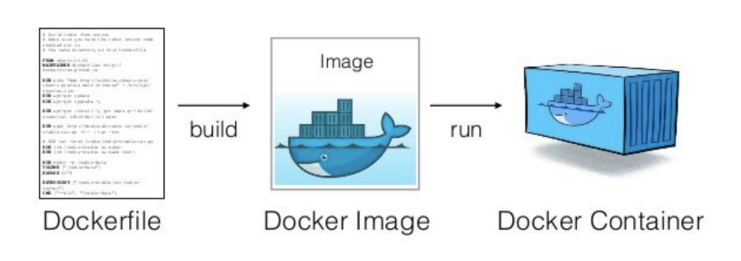

In [25]:
IMAGE_NAME = "trainer_image_exo"
IMAGE_TAG = "latest"
IMAGE_URI = f"gcr.io/{PROJECT_ID}/{IMAGE_NAME}:{IMAGE_TAG}"

os.environ["IMAGE_URI"] = IMAGE_URI

Building and pushing the container to the container registry:

In [ ]:
!gcloud builds submit --tag $IMAGE_URI $TRAINING_APP_FOLDER

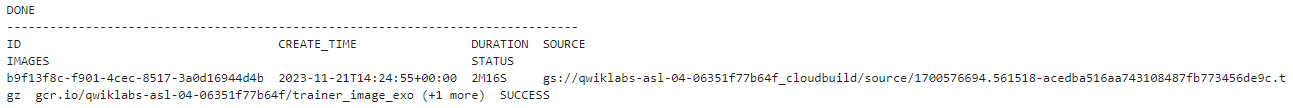